[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HSF-reco-and-software-triggers/Tracking-ML-Exa.TrkX/blob/master/Examples/TrackML_Quickstart/DM_colab_quickstart.ipynb)

# QuirkTacking 

# Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append("../../")
from Scripts import train_metric_learning, run_metric_learning_inference, train_gnn, run_gnn_inference, build_track_candidates, evaluate_candidates
from Scripts.utils.convenience_utils import get_example_data, plot_true_graph, plot_true_graph_select,get_training_metrics, plot_training_metrics, plot_neighbor_performance, plot_predicted_graph, plot_track_lengths, plot_edge_performance, plot_graph_sizes
import yaml

import warnings
warnings.filterwarnings("ignore")
CONFIG = 'pipeline_config.yaml'

/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading BokehJS ...

Loading BokehJS ...

## TrackML Dataset

The TrackML dataset contains simulated indepedent proton-proton collision events, each generating hundreds of particles, each of which hits cells and layers of the detector layers multiple times. The detector records the spatial coordinates and other auxillary information of these hits which, if properly connected, form tracks associated with the parent particle and the collision event from which it originates. The challenge and goal of this project is to associate each and every hit to one single track with optimal purity and efficiency, whose precise definition will be given later.

Each entry in the particles data frame contains a unique identifier of the particle (particle_id), its charge (q), its initial position or vertex $(v_x, v_y, v_z)$, its initial momentum in GeV/c $(p_x, p_y, p_z)$ and its associated number of detector hits. 

Many particles do not leave behind any detector hits and obviously cannot be associated to any track. This is called "detector inefficiency". They are among "uninterested particles" and will be mostly filtered out by a simple momentum cut.

### Training data
Let us take a look at the data before training. In this example pipeline, we have preprocessed the TrackML data into a more convenient form. We calculated directional information and summary statistics from the charge deposited in each spacepoints, and append them to its cyclidrical coordinates. Let us load an example data file and inspect the content.

In [ ]:
with open(CONFIG, 'r') as f:
    configs = yaml.load(f, Loader=yaml.FullLoader)

In [ ]:
example_data_df, example_data_pyg = get_example_data(configs)
example_data_df.head()
example_data_pyg

Data(x=[895, 3], pid=[895], event_file='datasets/Lambda500/feature_store/QuirkTracking_sample/1001', hid=[895], pt=[895], modulewise_true_edges=[2, 782], layerwise_true_edges=[2, 782], signal_true_edges=[2, 782])

In [ ]:
example_data_pyg

Data(x=[895, 3], pid=[895], event_file='datasets/Lambda500/feature_store/QuirkTracking_sample/1001', hid=[895], pt=[895], modulewise_true_edges=[2, 782], layerwise_true_edges=[2, 782], signal_true_edges=[2, 782])

### Visualize tracks

A "true track" is defined as a set of sequential hits, all left by the same particle. Therefore a true edge is the edge formed by two sequential hits. Let's visualize a random set of 200 true tracks:

In [ ]:

#plot_true_graph_select(example_data_pyg, num_tracks=200, selected_pid=1160)
#plot_true_graph_select(example_data_pyg, num_tracks=200, selected_pid=1161)

In [ ]:
plot_true_graph(example_data_pyg, num_tracks=200)

# 1. Train Metric Learning

## Train metric learning model

Finally we come to model training. By default, we train the MLP for 30 epochs, which takes approximately 15 minutes on an NVidia V100. Feel free to adjust the epoch number in pipeline_config.yml

In [ ]:
metric_learning_trainer, metric_learning_model = train_metric_learning(CONFIG)

-------------------- Step 1: Running metric learning training --------------------
----------------------------- a) Initialising model -----------------------------
------------------------------ b) Running training ------------------------------
[Data(x=[60, 3], pid=[60], event_file='datasets/Lambda500/feature_store/QuirkTracking_sample/2111', hid=[60], pt=[60], modulewise_true_edges=[2, 14], layerwise_true_edges=[2, 184], signal_true_edges=[2, 14]), Data(x=[18, 3], pid=[18], event_file='datasets/Lambda500/feature_store/QuirkTracking_sample/2112', hid=[18], pt=[18], modulewise_true_edges=[2, 14], layerwise_true_edges=[2, 18], signal_true_edges=[2, 14]), Data(x=[16, 3], pid=[16], event_file='datasets/Lambda500/feature_store/QuirkTracking_sample/2113', hid=[16], pt=[16], modulewise_true_edges=[2, 14], layerwise_true_edges=[2, 14], signal_true_edges=[2, 14]), Data(x=[139, 3], pid=[139], event_file='datasets/Lambda500/feature_store/QuirkTracking_sample/2114', hid=[139], pt=[139], modulewi

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | network | Sequential | 3.2 M 
---------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.694    Total estimated model params size (MB)


Epoch 149: 100%|██████████| 900/900 [03:42<00:00,  4.05it/s, loss=0.00599, v_num=1]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 900/900 [03:42<00:00,  4.04it/s, loss=0.00599, v_num=1]
-------------------------------- c) Saving model --------------------------------


## Plot training metrics

We can examine how the training went. This is stored in a simple dataframe:

In [ ]:
embedding_metrics = get_training_metrics(metric_learning_trainer)
embedding_metrics.head()

epoch  train_loss  val_loss       eff       pur  current_lr
0      0    0.007289  0.005852  0.727527  0.121812    0.000125
1      1    0.007045  0.005766  0.648434  0.121945    0.000250
2      2    0.006966  0.005643  0.608489  0.125334    0.000375
3      3    0.006757  0.005585  0.595632  0.123860    0.000500
4      4    0.006647  0.005541  0.574918  0.123426    0.000625

In [ ]:
plot_training_metrics(embedding_metrics)

## Evaluate model performance on sample test data

Here we evaluate the model performace on one sample test data. We look at how the efficiency and purity change with the embedding radius.

In [ ]:
plot_neighbor_performance(metric_learning_model)

cuda
Data(x=[60, 3], pid=[60], event_file='datasets/Lambda500/feature_store/QuirkTracking_sample/2111', hid=[60], pt=[60], modulewise_true_edges=[2, 14], layerwise_true_edges=[2, 184], signal_true_edges=[2, 14])


## Plot example truth and predicted graphs

In [ ]:
plot_predicted_graph(metric_learning_model)

Data(x=[60, 3], pid=[60], event_file='datasets/Lambda500/feature_store/QuirkTracking_sample/2111', hid=[60], pt=[60], modulewise_true_edges=[2, 14], layerwise_true_edges=[2, 184], signal_true_edges=[2, 14])
tensor([14, 14], device='cuda:0')
tensor([1066., 1067.], device='cuda:0', dtype=torch.float64)


In [ ]:
sample_event = metric_learning_model.trainset[0]

In [ ]:
sample_event

Data(x=[762, 3], pid=[762], event_file='datasets/Lambda500/feature_store/QuirkTracking_sample/1000', hid=[762], pt=[762], modulewise_true_edges=[2, 665], layerwise_true_edges=[2, 665], signal_true_edges=[2, 665])

In [ ]:
#import numpy as np
#unique_elements = np.unique(sample_event.pid)
#print(unique_elements)

In [ ]:
embedding = metric_learning_model.cuda()(sample_event.x.cuda()).cpu()

In [ ]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(embedding.detach())

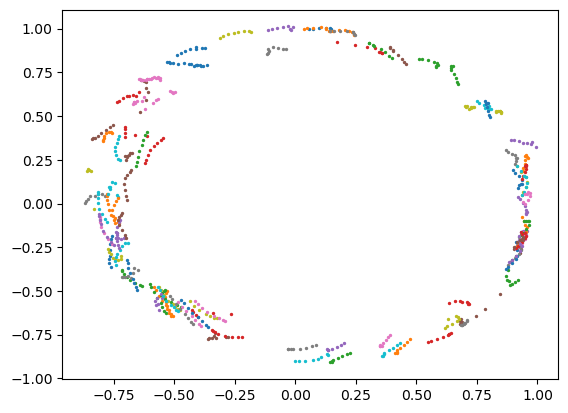

In [ ]:
import matplotlib.pyplot as plt
for pid in sample_event.pid.unique():
    
    plt.scatter(embedding_2d[sample_event.pid==pid, 0], embedding_2d[sample_event.pid==pid, 1], s=2)

## Track lengths

In [ ]:
plot_track_lengths(metric_learning_model)

100%|██████████| 800/800 [02:48<00:00,  4.75it/s]


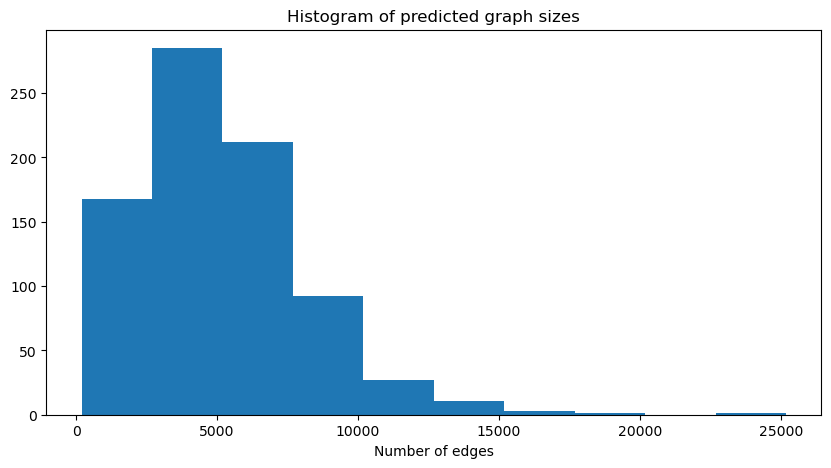

In [ ]:
plot_graph_sizes(metric_learning_model)

# 2. Construct graphs from metric learning inference

This step performs model inference on the entire input datasets (train, validation and test), to obtain input graphs to the graph neural network. Optionally, we also clear the directory.

In [ ]:
graph_builder = run_metric_learning_inference(CONFIG)

------------- Step 2: Constructing graphs from metric learning model -------------
---------------------------- a) Loading trained model ----------------------------
----------------------------- b) Running inferencing -----------------------------
Training finished, running inference to build graphs...


100%|██████████| 100/100 [00:31<00:00,  3.13it/s]


# 3. Train graph neural networks

We have a set of graphs constructed. We now train a GNN to classify edges as either "true" (belonging to the same track) or "false" (not belonging to the same track).

In [ ]:
gnn_trainer, gnn_model = train_gnn(CONFIG)

-------------------------  Step 3: Running GNN training  -------------------------
----------------------------- a) Initialising model -----------------------------
------------------------------ b) Running training ------------------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | node_encoder           | Sequential | 34.0 K
1 | edge_encoder           | Sequential | 66.4 K
2 | edge_network           | Sequential | 82.8 K
3 | node_network           | Sequential | 82.8 K
4 | output_edge_classifier | Sequential | 83.2 K
------------------------------------------------------
349 K     Trainable params
0         Non-trainable params
349 K     Total params
1.397     Total estimated model params size (MB)


Epoch 299: 100%|██████████| 900/900 [01:10<00:00, 12.82it/s, loss=0.00292, v_num=2] 

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 900/900 [01:10<00:00, 12.79it/s, loss=0.00292, v_num=2]
-------------------------------- c) Saving model --------------------------------


## Plot training metrics

In [ ]:
gnn_metrics = get_training_metrics(gnn_trainer)
gnn_metrics.head()

epoch  train_loss  val_loss       eff       pur  current_lr
0      0    0.156089  1.387594  0.344084  0.490342      0.0001
1      1    0.092336  1.848424  0.375021  0.488306      0.0002
2      2    0.065138  1.979680  0.383538  0.470932      0.0003
3      3    0.051835  1.947514  0.401947  0.484944      0.0004
4      4    0.041366  1.878381  0.359099  0.495866      0.0005

In [ ]:
plot_training_metrics(gnn_metrics)

## Evaluate model performance on sample test data

Here we evaluate the model performace on one sample test data. We look at how the efficiency and purity change with the embedding radius.

In [ ]:
plot_edge_performance(gnn_model)

# Step 4: GNN inference 

In [ ]:
run_gnn_inference(CONFIG)

--------------------- Step 4: Scoring graph edges using GNN  ---------------------
---------------------------- a) Loading trained model ----------------------------
----------------------------- b) Running inferencing -----------------------------
Training finished, running inference to filter graphs...
Building train


100%|██████████| 800/800 [00:46<00:00, 17.22it/s]


Building val


100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Building test


100%|██████████| 100/100 [00:04<00:00, 23.89it/s]


# Step 5: Build track candidates from GNN

In [48]:
build_track_candidates(CONFIG)

-----------  Step 5: Building track candidates from the scored graph  -----------
---------------------------- a) Loading scored graphs ----------------------------
---------------------------- b) Labelling graph nodes ----------------------------


100%|██████████| 200/200 [00:08<00:00, 24.52it/s]


# Step 6: Evaluate track candidates

We can control the matching style in the pipeline config file. The following all require at least a majority of hits to match in each scheme (i.e. matching fraction = 50%).
A discussion of each matching style and some worked examples can be found in the [Documentation](https://hsf-reco-and-software-triggers.github.io/Tracking-ML-Exa.TrkX/performance/matching_definitions/).

ATLAS style matching is the default.

------------ Step 6: Evaluating the track reconstruction performance ------------
--------------------------- a) Loading labelled graphs ---------------------------


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]


--------------------- b) Calculating the performance metrics ---------------------
Number of reconstructed particles: 30
Number of particles: 400
Number of matched tracks: 180
Number of tracks: 217
Number of duplicate reconstructed particles: 2
Efficiency: 0.075
Fake rate: 0.171
Duplication rate: 0.067
------------------------------ c) Plotting results ------------------------------


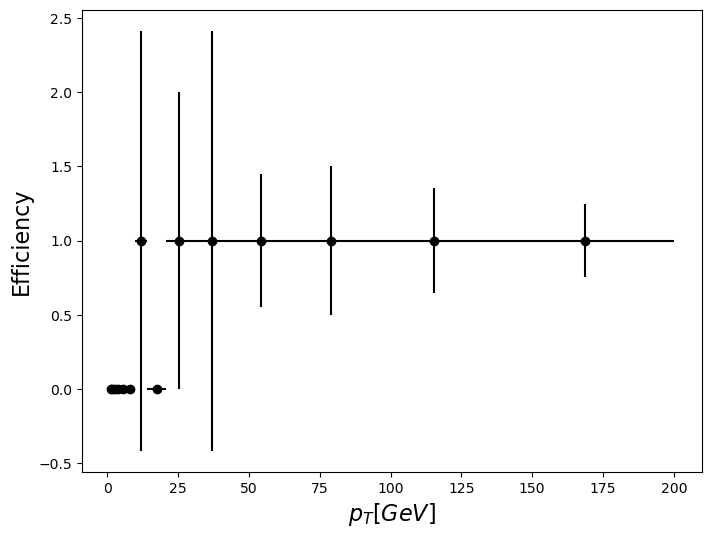

In [2]:
evaluated_events, reconstructed_particles, particles, matched_tracks, tracks, reconstruct_data, particles_data = evaluate_candidates(CONFIG)

In [27]:
print(reconstruct_data)

     track_id  particle_id  n_shared  n_reco_hits  n_true_hits           pt  \
0           2       1649.0         4            7            8   334.133013   
1           2       1649.0         4            7            8   334.133013   
2           2       1649.0         4            7            8   334.133013   
3           2       1649.0         4            7            8   334.133013   
4           3       1513.0         3            5            8    68.740592   
..        ...          ...       ...          ...          ...          ...   
157         1       1149.0         8            8           10  1584.983462   
158         1       1149.0         8            8           10  1584.983462   
159         1       1149.0         8            8           10  1584.983462   
160         1       1149.0         8            8           10  1584.983462   
161         1       1149.0         8            8           10  1584.983462   

     event_id  purity_reco  eff_true  hit_id  ...  

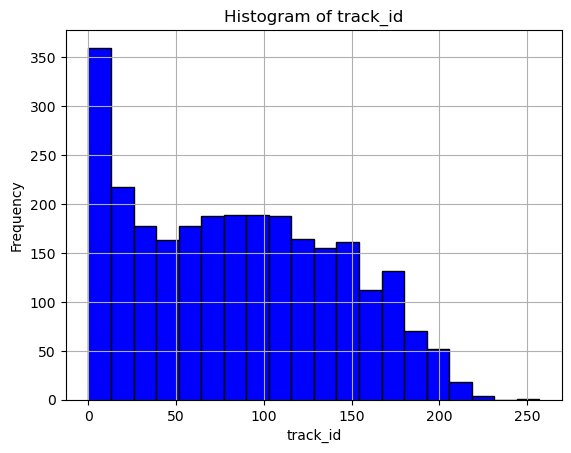

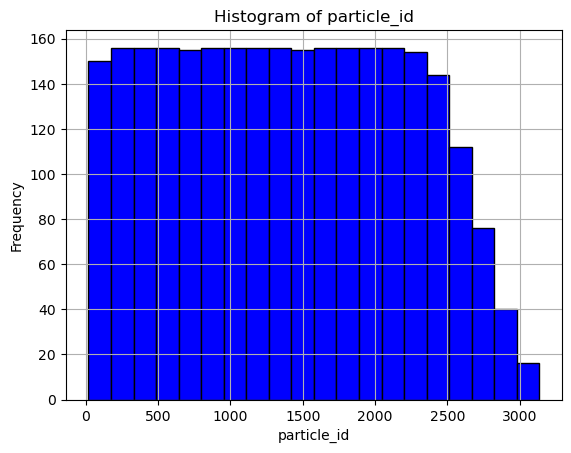

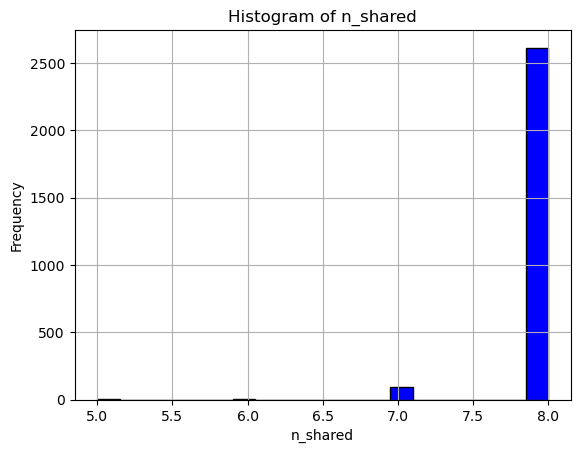

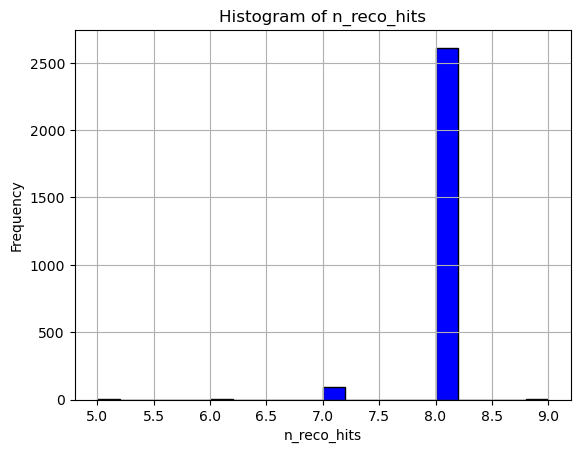

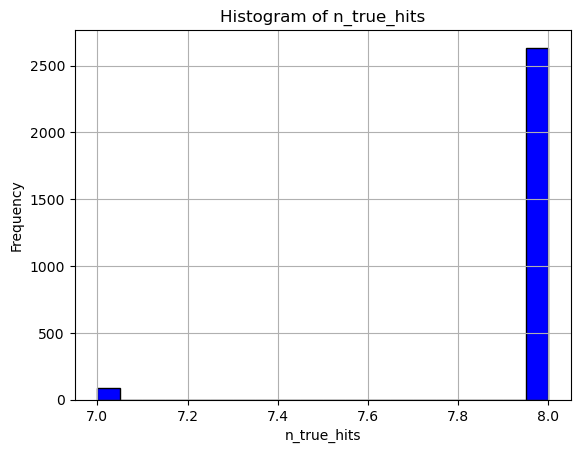

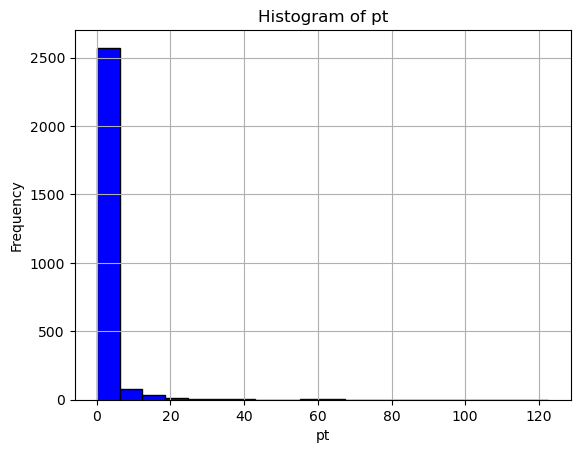

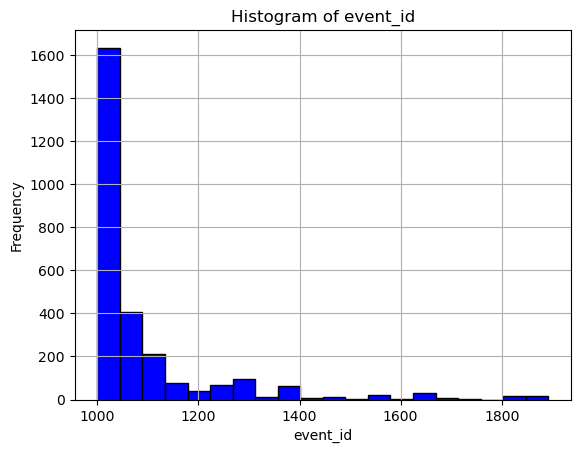

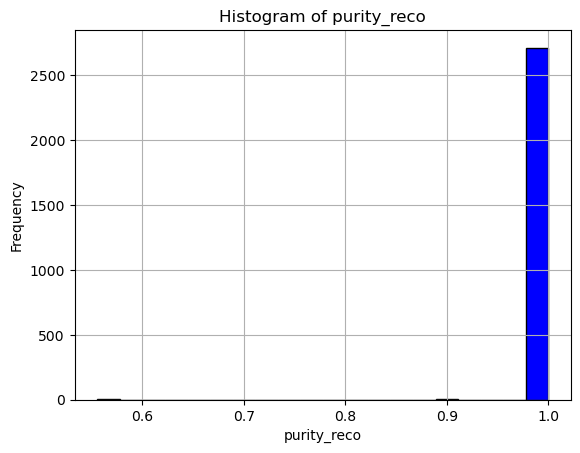

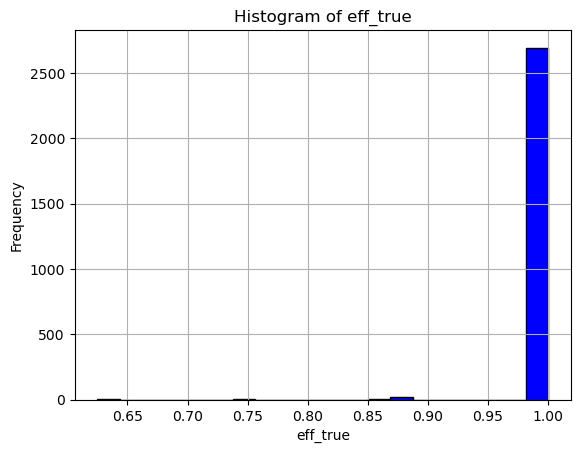

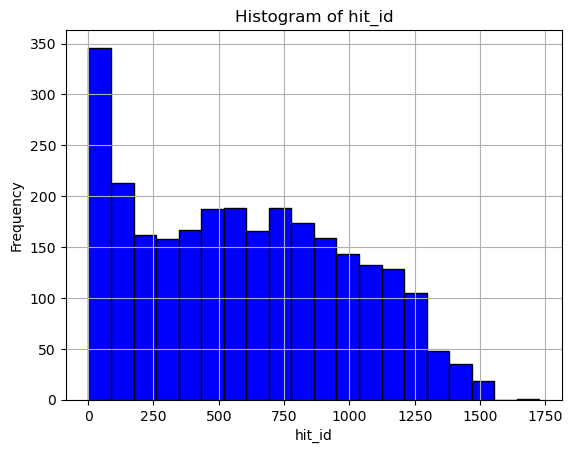

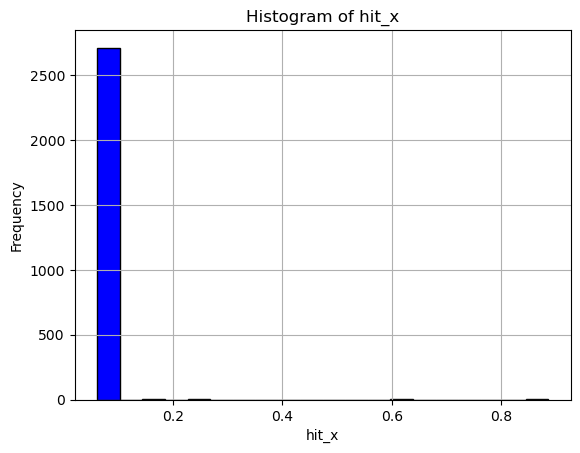

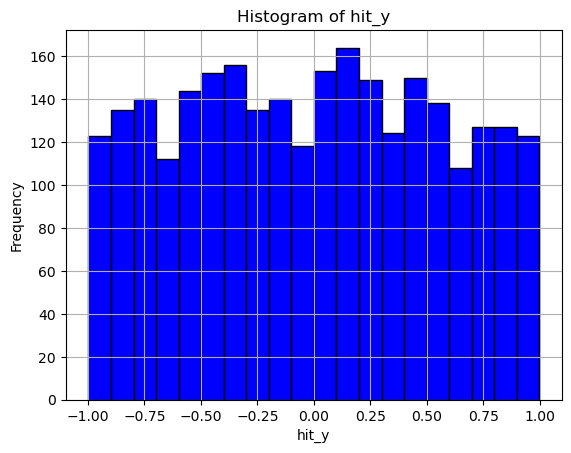

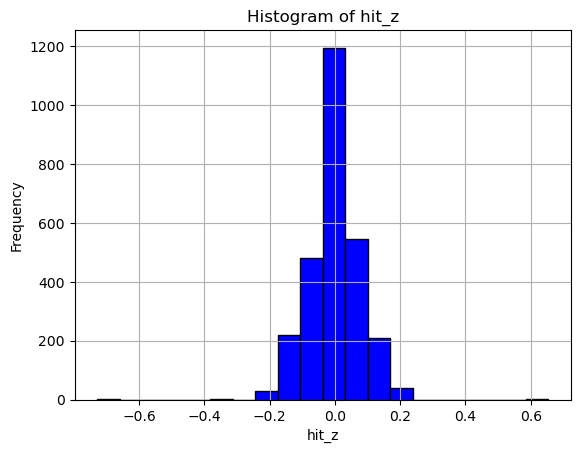

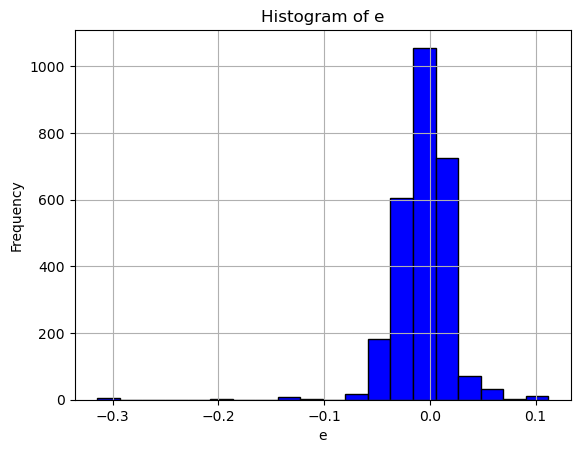

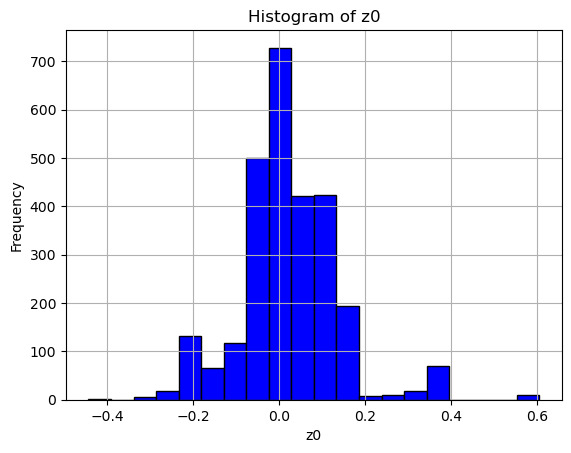

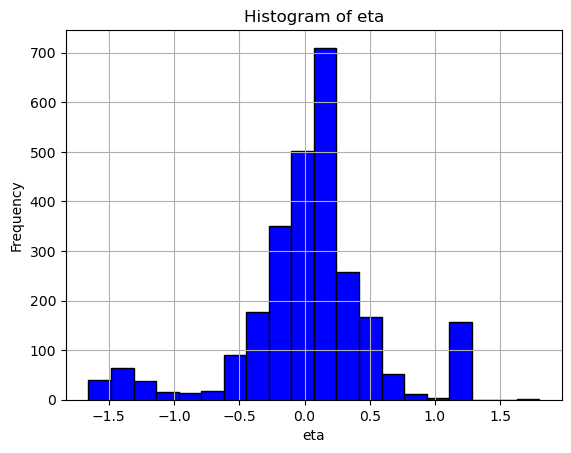

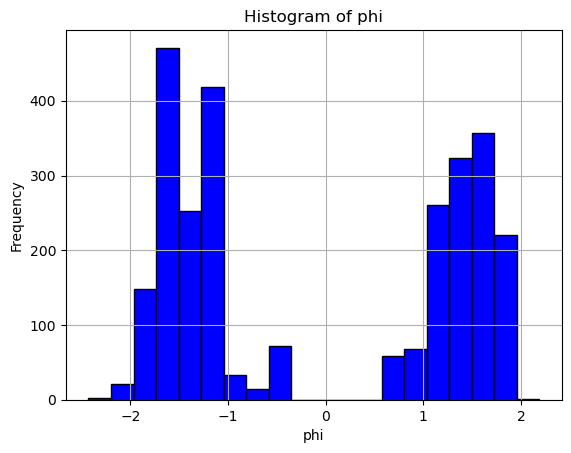

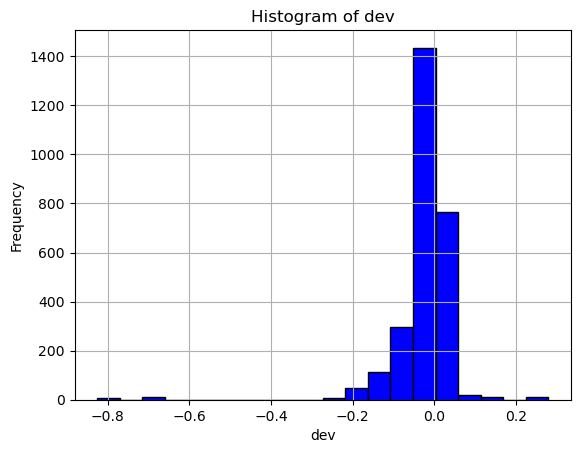

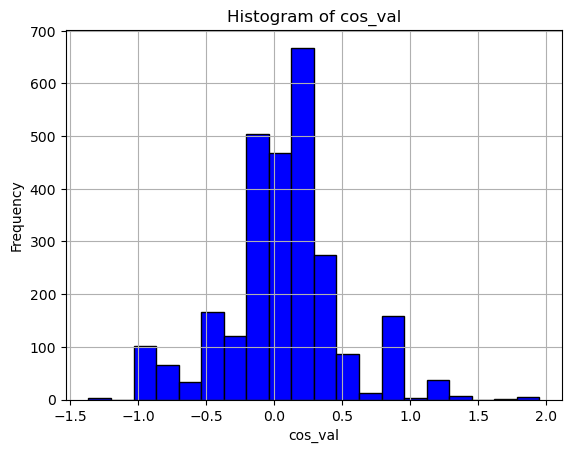

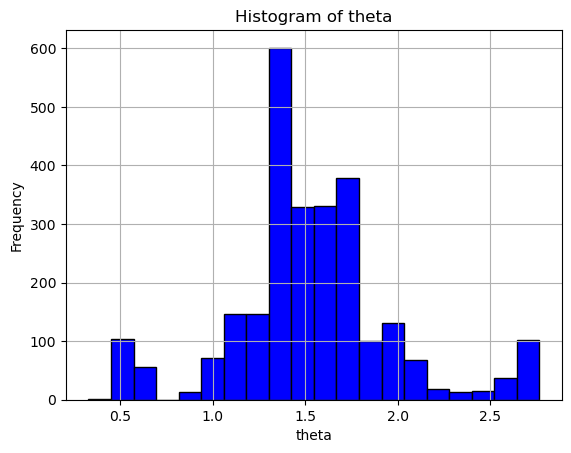

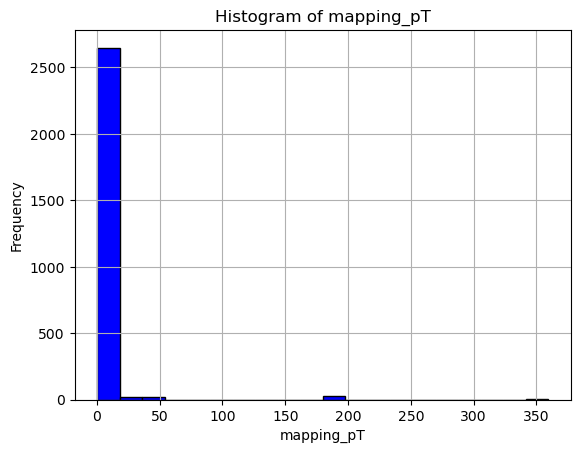

INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


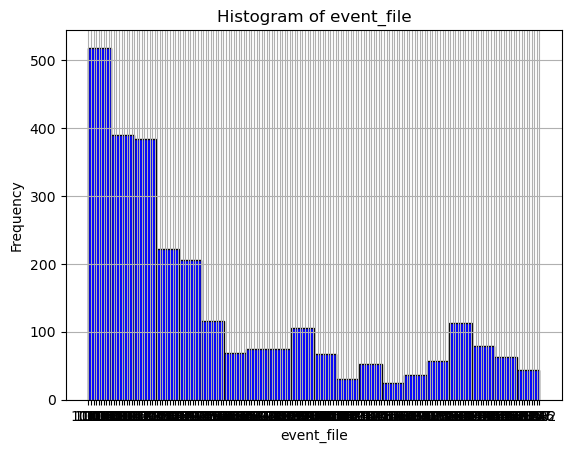

In [33]:
reconstruct_data_reduce = reconstruct_data.drop_duplicates(subset=['particle_id'])
#print(reconstruct_data_reduce)

import matplotlib.pyplot as plt
import pandas as pd

# 假设reconstruct_data是一个Pandas DataFrame
for column_name in reconstruct_data_reduce.columns:
    # 获取每一列的数据
    column_data = reconstruct_data_reduce[column_name]
    
    # 绘制直方图
    plt.hist(column_data, bins=20, color='blue', edgecolor='black')
    
    # 设置标题、横坐标和纵坐标
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column_name}')
    
    # 显示网格线
    plt.grid(True)
    
    # 显示每张图
    plt.show()

       track_id  particle_id  n_shared  n_reco_hits  n_true_hits           pt  \
0             0       1401.0         3            3           60   399.375335   
8             2       1402.0         4            7           60   409.054378   
120           0       1649.0         1            1            8   334.133013   
126           2       1650.0         3            7           10   244.183619   
174           0       1298.0         1            1            8   263.867445   
...         ...          ...       ...          ...          ...          ...   
12925         1       1588.0         1            2            8   283.528720   
12939         0        845.0         2            2            8   482.358773   
12945         4        846.0         2            3            8   282.743366   
12955         0       1148.0         8            8            8  1866.749545   
12963         1       1149.0         8            8           10  1584.983462   

       event_id  purity_rec

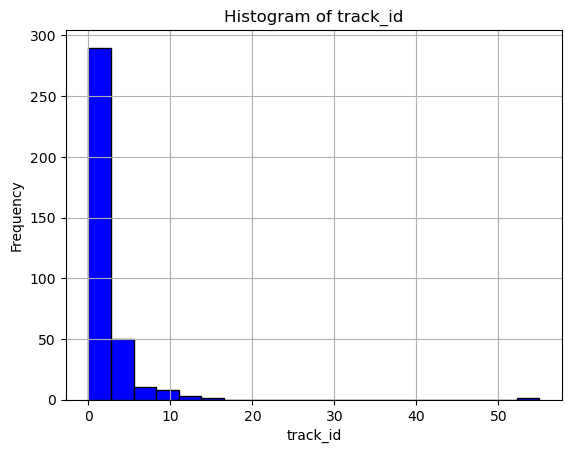

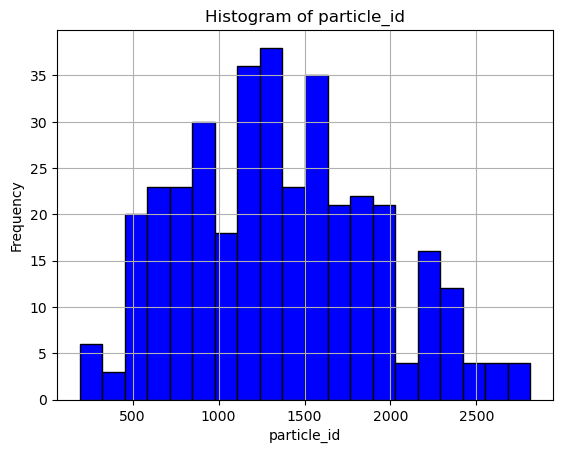

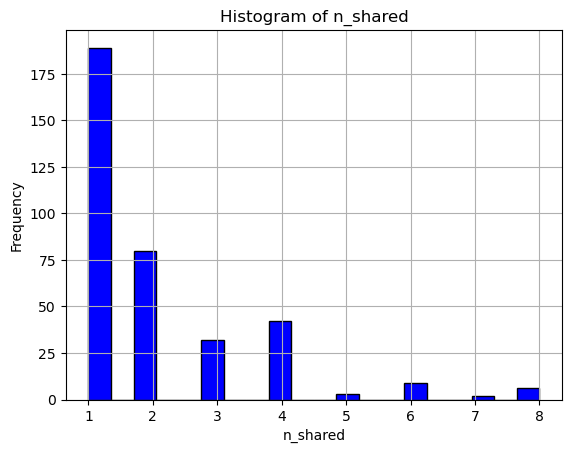

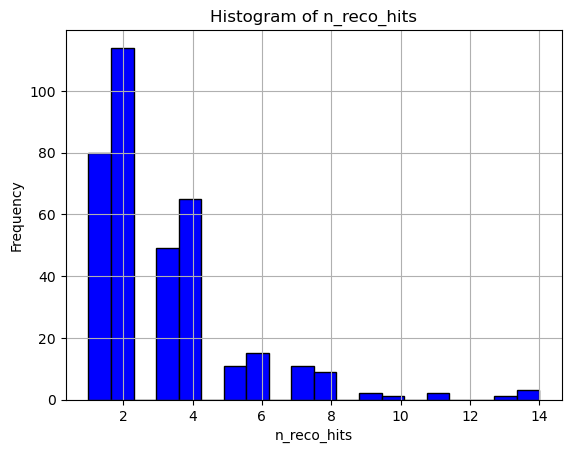

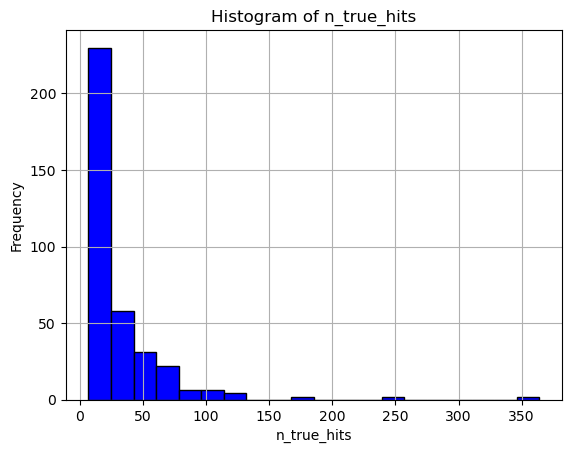

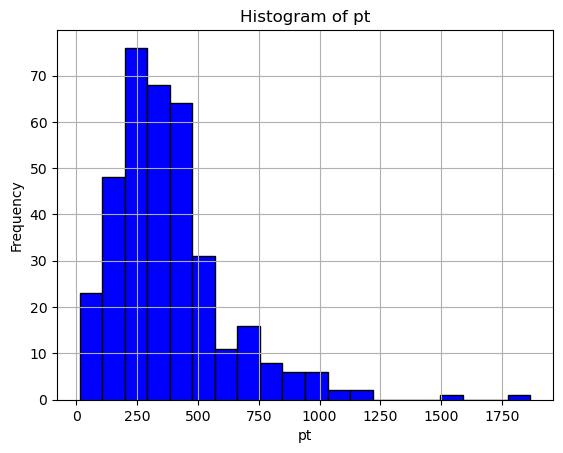

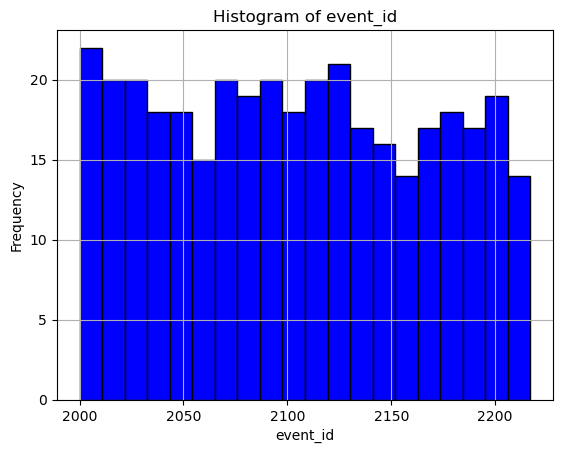

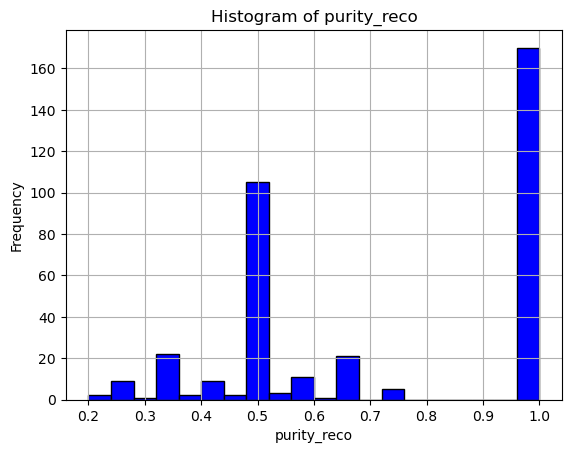

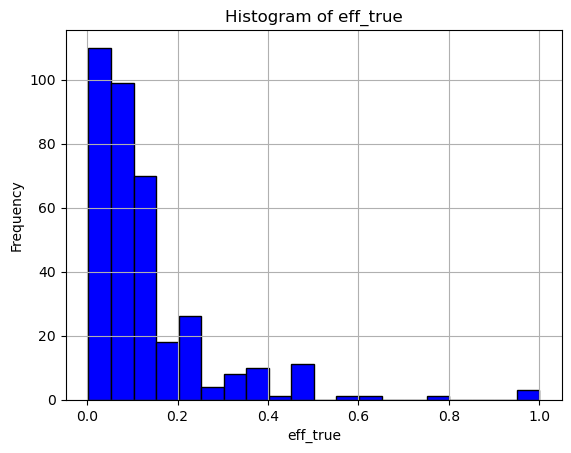

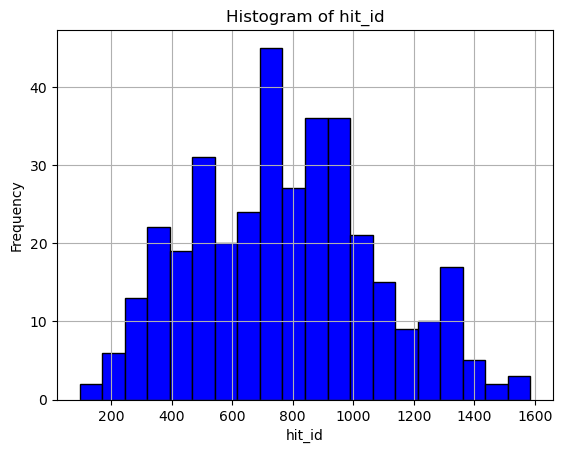

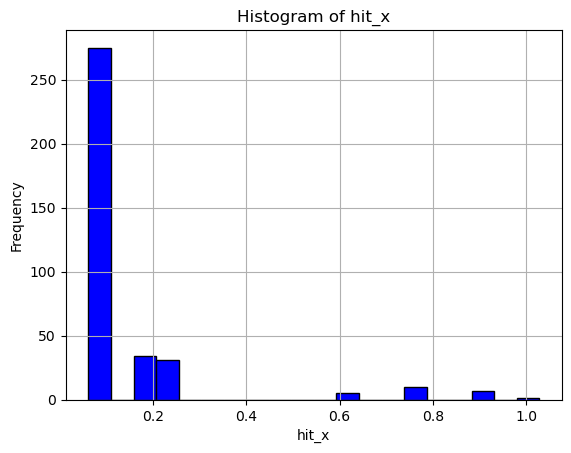

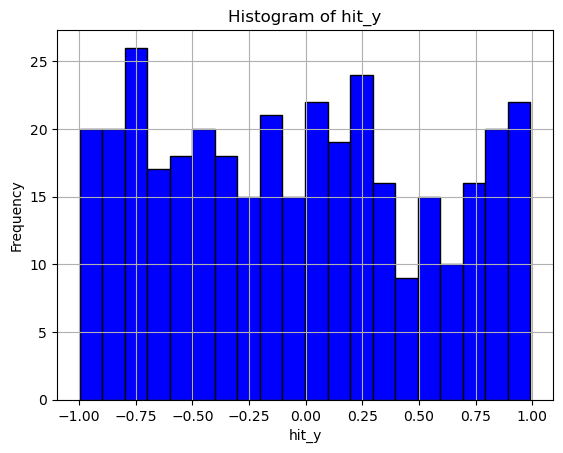

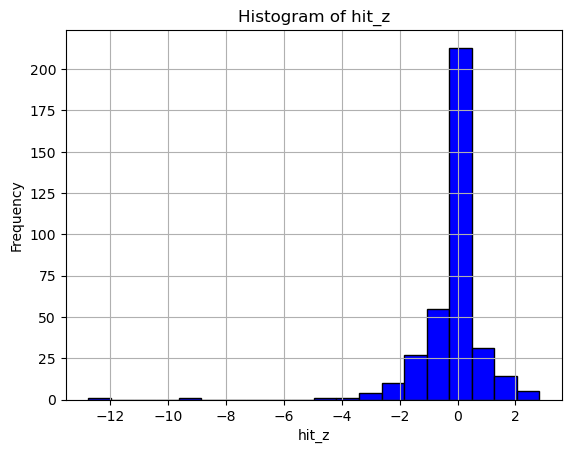

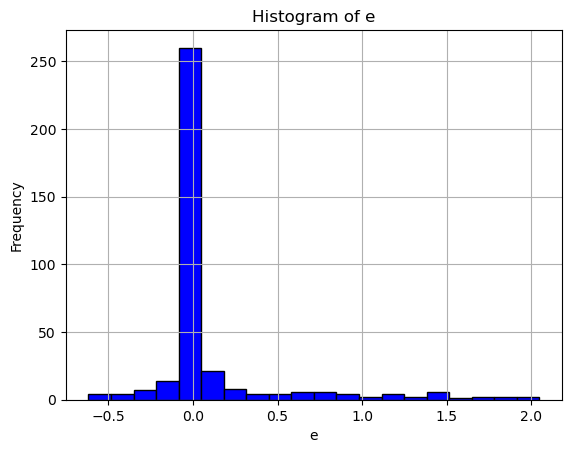

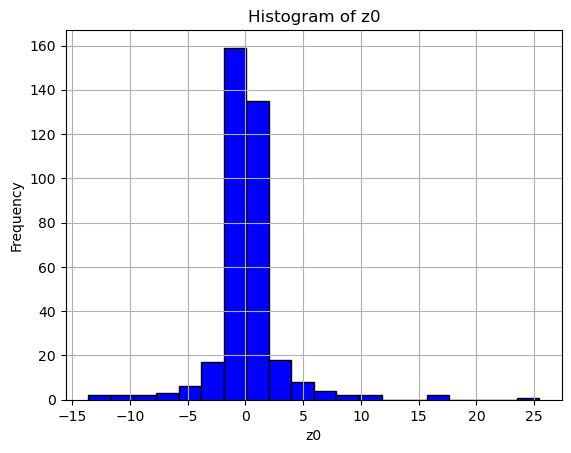

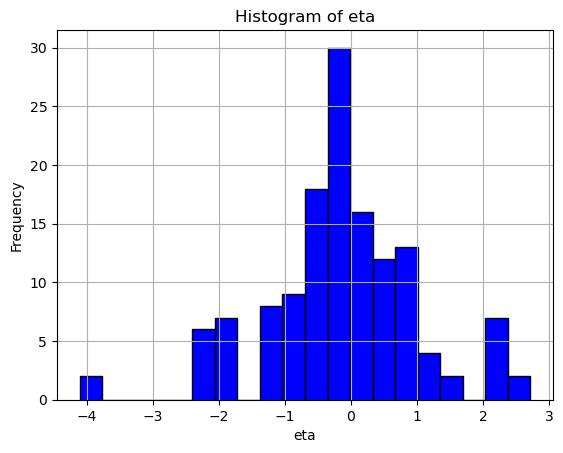

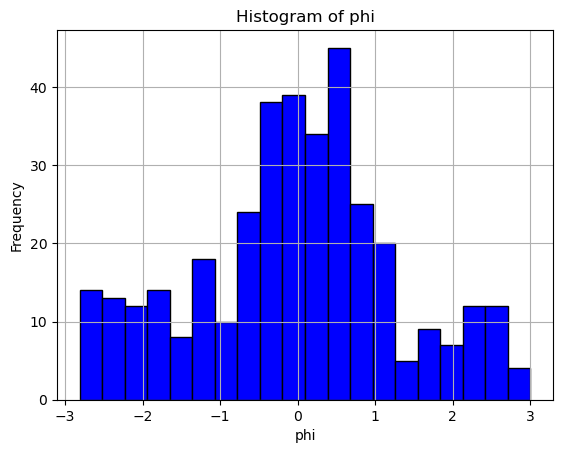

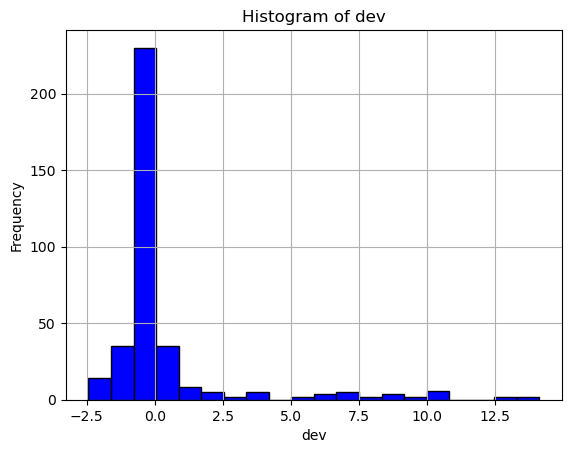

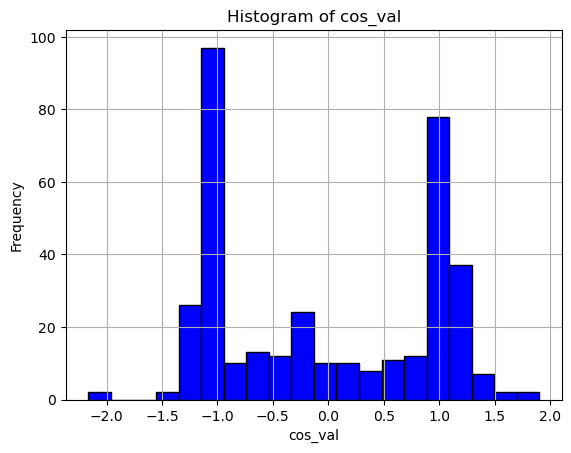

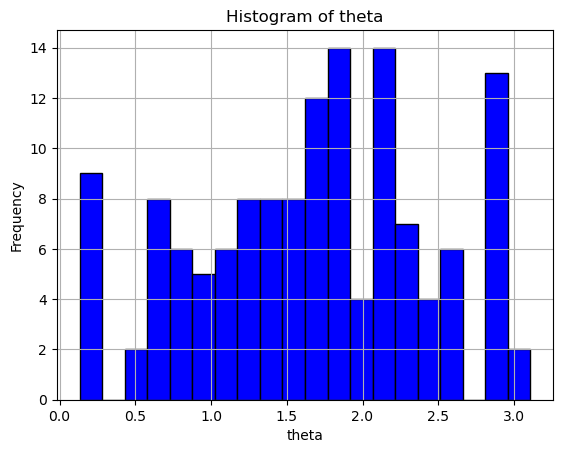

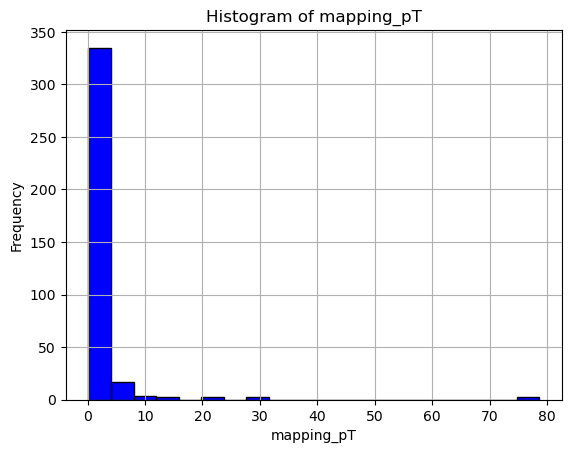

INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


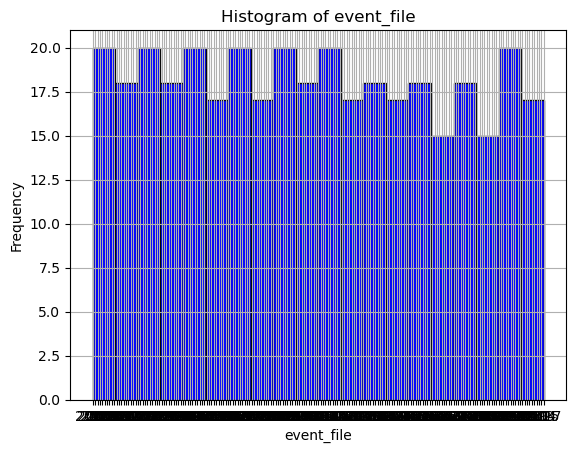

In [59]:
particles_data_reduce = particles_data.drop_duplicates(subset=['particle_id'])
print(particles_data_reduce)

import matplotlib.pyplot as plt
import pandas as pd

# 假设reconstruct_data是一个Pandas DataFrame
for column_name in particles_data_reduce.columns:
    # 获取每一列的数据
    column_data = particles_data_reduce[column_name]
    
    # 绘制直方图
    plt.hist(column_data, bins=20, color='blue', edgecolor='black')
    
    # 设置标题、横坐标和纵坐标
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column_name}')
    
    # 显示网格线
    plt.grid(True)
    
    # 显示每张图
    plt.show()

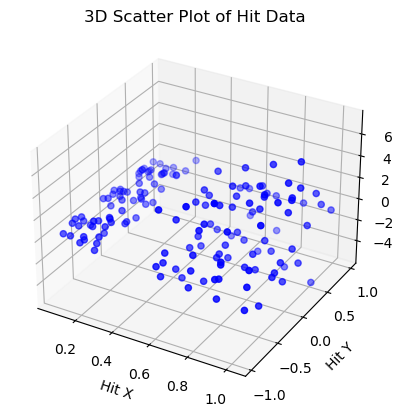

In [17]:
#print(reconstruct_data)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 导入3D绘图工具

# 假设reconstruct_data是一个Pandas DataFrame
x = reconstruct_data["hit_x"]
y = reconstruct_data["hit_y"]
z = reconstruct_data["hit_z"]

# 创建一个3D图形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图
ax.scatter(x, y, z, c='blue', marker='o')

# 设置坐标轴标签
ax.set_xlabel('Hit X')
ax.set_ylabel('Hit Y')
ax.set_zlabel('Hit Z')

# 设置图形标题
ax.set_title('3D Scatter Plot of Hit Data')

# 显示图形
plt.show()

Particle ID: 19.0, Event ID: 1892


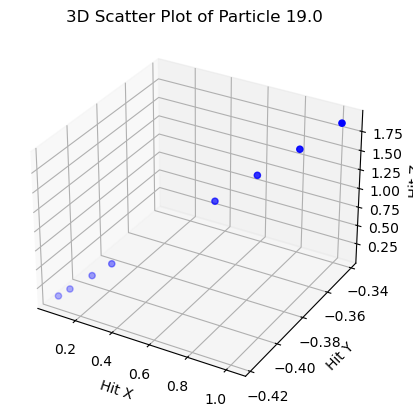

Particle ID: 25.0, Event ID: 1531


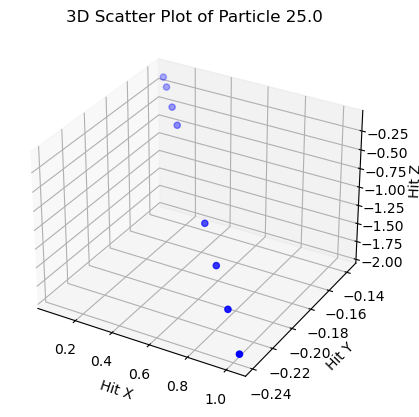

Particle ID: 26.0, Event ID: 1531


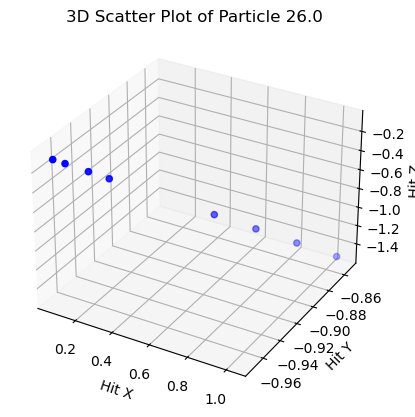

Particle ID: 27.0, Event ID: 1531


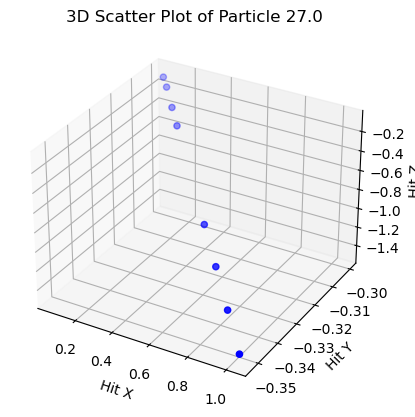

Particle ID: 28.0, Event ID: 1196


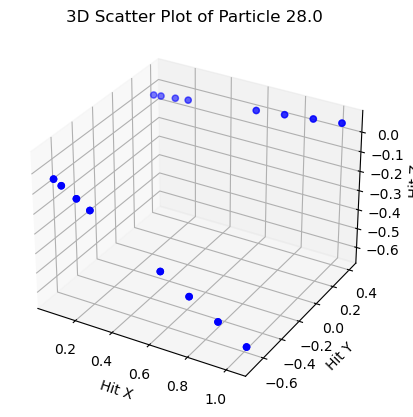

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设reconstruct_data是一个Pandas DataFrame
grouped_data = reconstruct_data.groupby('particle_id')

count = 0
for particle_id, group in grouped_data:
    if count < 5:
        x = group["hit_x"]
        y = group["hit_y"]
        z = group["hit_z"]

    # 创建一个3D图形
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    # 绘制散点图
        ax.scatter(x, y, z, c='blue', marker='o')

    # 设置坐标轴标签
        ax.set_xlabel('Hit X')
        ax.set_ylabel('Hit Y')
        ax.set_zlabel('Hit Z')
        
        event_id = group.iloc[0]['event_id']
        print(f'Particle ID: {particle_id}, Event ID: {event_id}')

    # 设置图形标题
        ax.set_title(f'3D Scatter Plot of Particle {particle_id}')
        count += 1
    else:
        break

    # 显示图形
    plt.show()

Particle ID: 290.0, Event ID: 2192


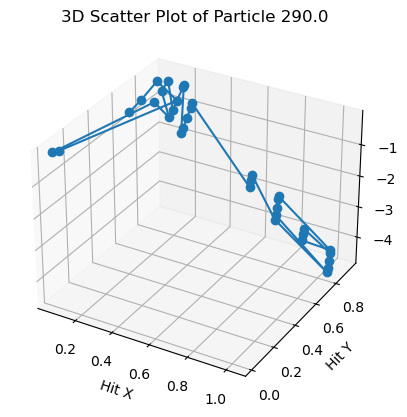

Particle ID: 291.0, Event ID: 2192


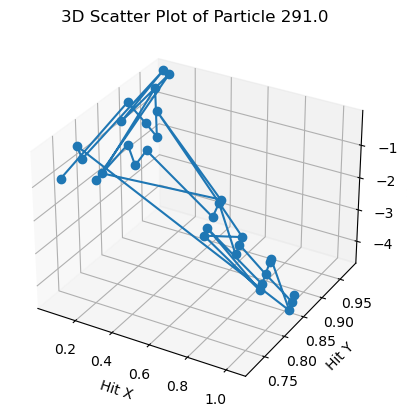

Particle ID: 318.0, Event ID: 2200


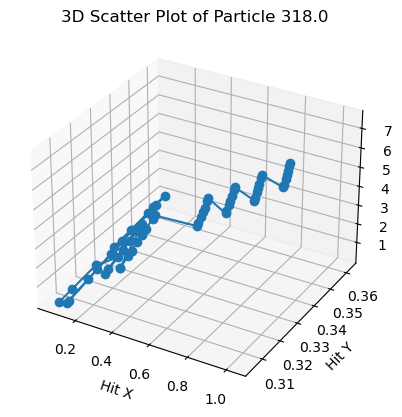

Particle ID: 319.0, Event ID: 2200


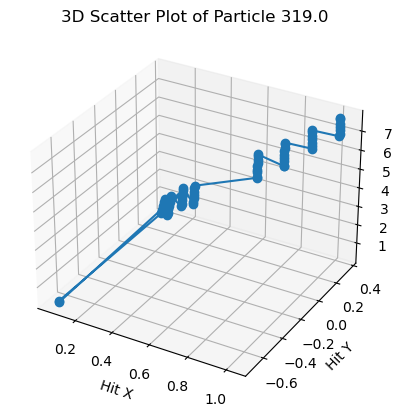

Particle ID: 407.0, Event ID: 2156


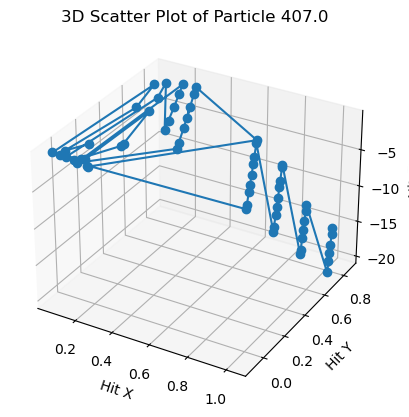

Particle ID: 408.0, Event ID: 2156


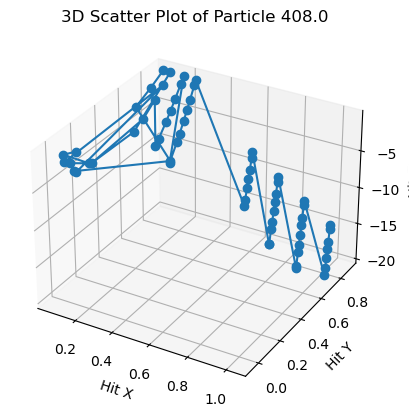

Particle ID: 459.0, Event ID: 2065


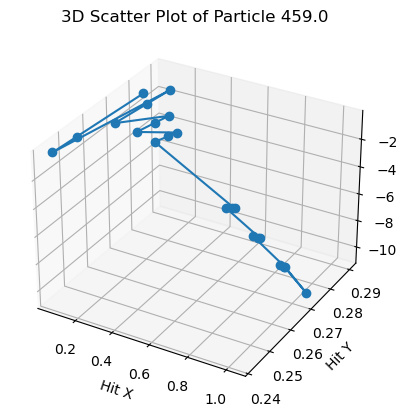

Particle ID: 460.0, Event ID: 2065


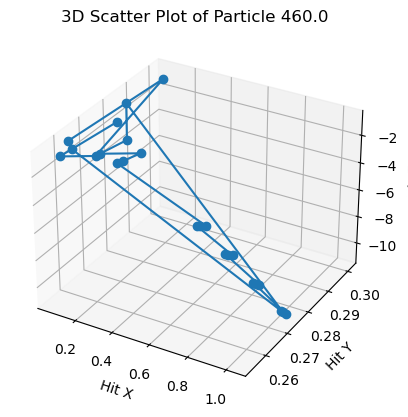

Particle ID: 475.0, Event ID: 2046


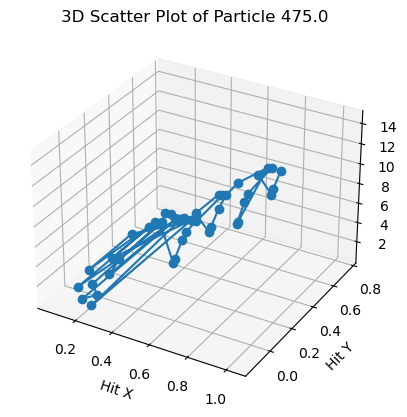

Particle ID: 476.0, Event ID: 2046


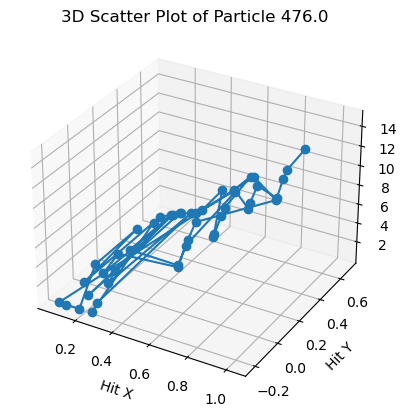

Particle ID: 488.0, Event ID: 2102


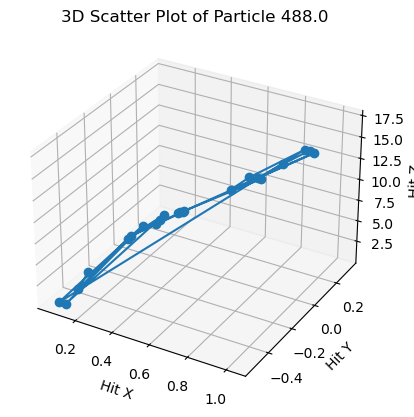

Particle ID: 504.0, Event ID: 2058


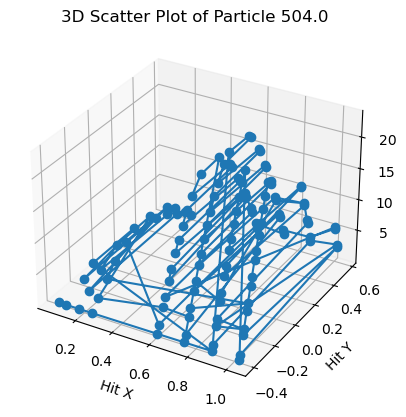

Particle ID: 505.0, Event ID: 2058


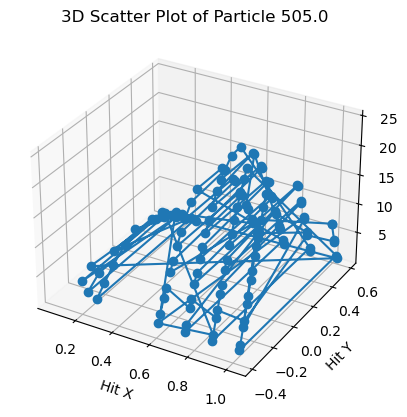

Particle ID: 524.0, Event ID: 2137


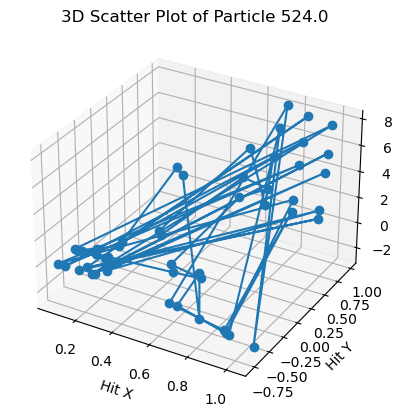

Particle ID: 525.0, Event ID: 2137


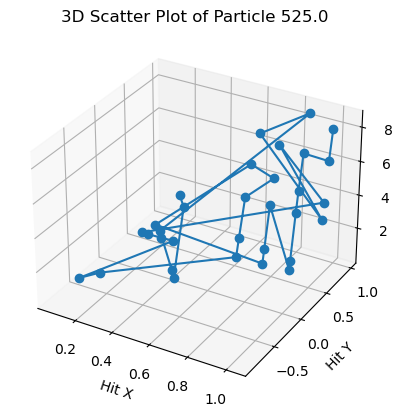

Particle ID: 528.0, Event ID: 2043


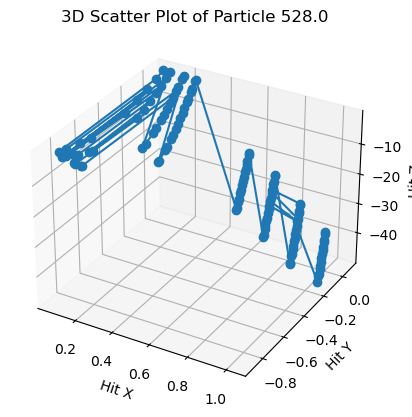

Particle ID: 529.0, Event ID: 2043


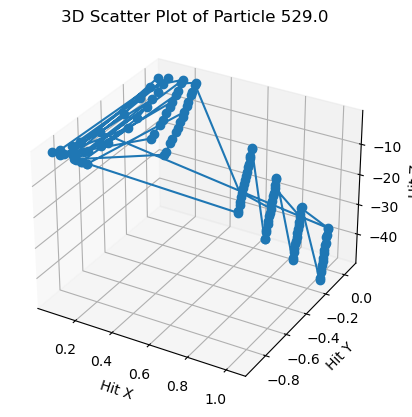

Particle ID: 546.0, Event ID: 2133


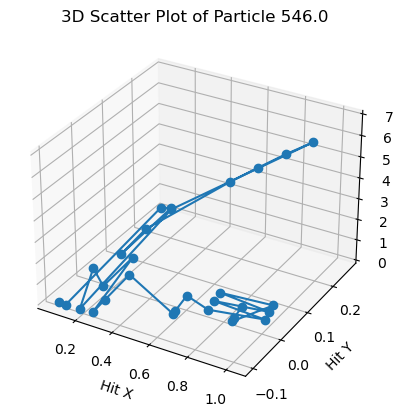

Particle ID: 547.0, Event ID: 2133


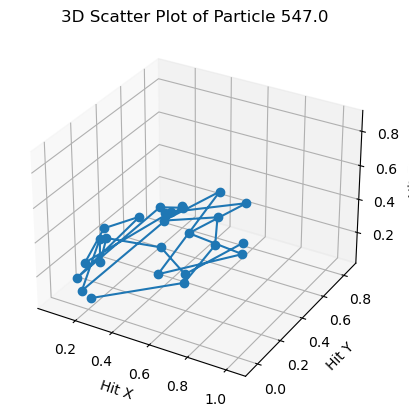

Particle ID: 647.0, Event ID: 2196


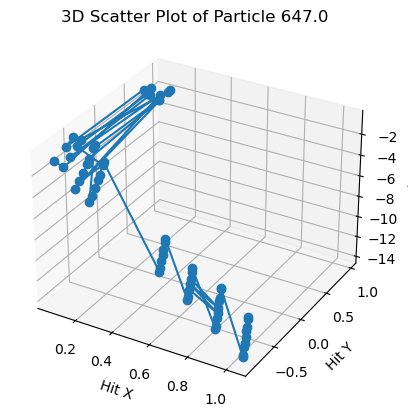

Particle ID: 648.0, Event ID: 2196


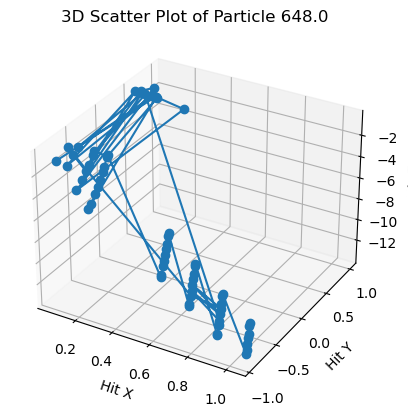

Particle ID: 655.0, Event ID: 2174


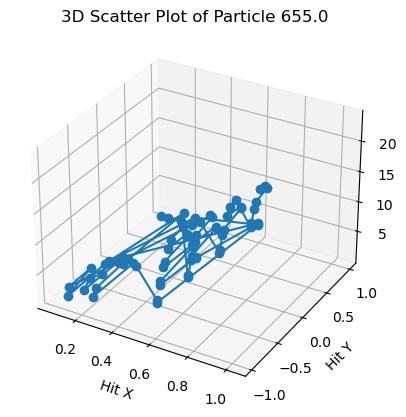

Particle ID: 657.0, Event ID: 2174


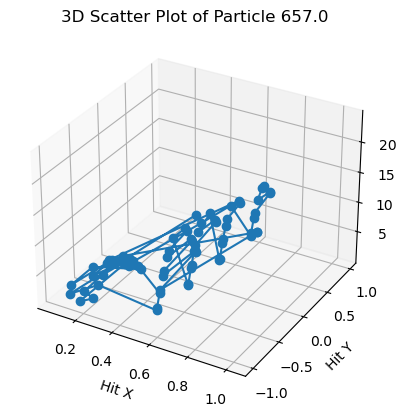

Particle ID: 700.0, Event ID: 2149


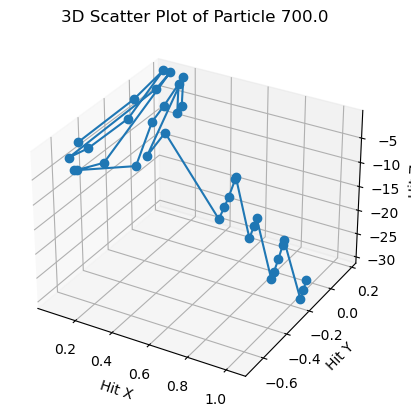

Particle ID: 701.0, Event ID: 2070


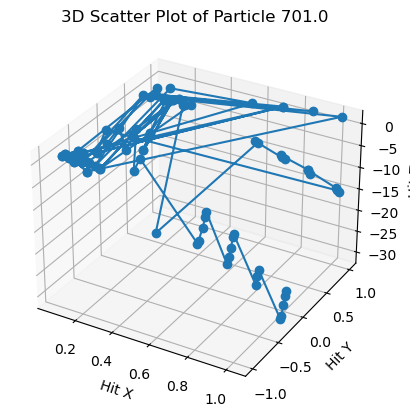

Particle ID: 702.0, Event ID: 2070


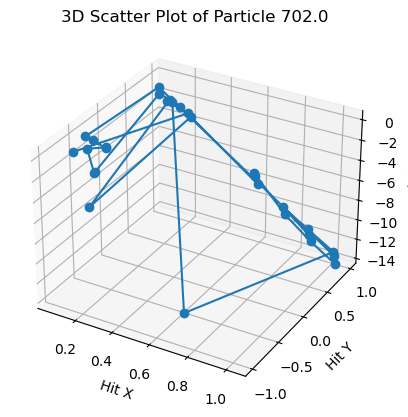

Particle ID: 707.0, Event ID: 2036


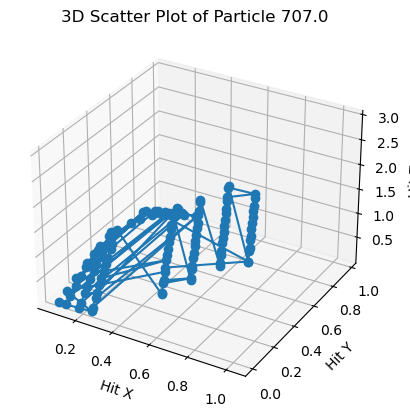

Particle ID: 708.0, Event ID: 2036


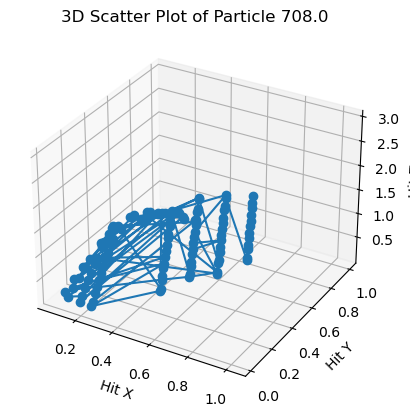

Particle ID: 711.0, Event ID: 2206


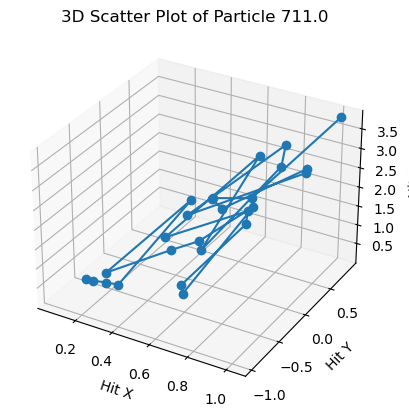

Particle ID: 712.0, Event ID: 2206


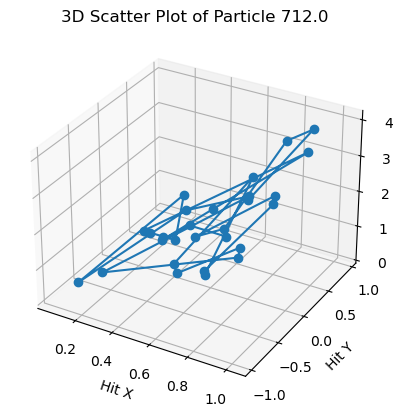

Particle ID: 720.0, Event ID: 2187


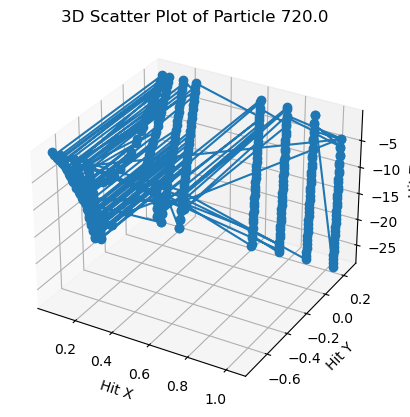

Particle ID: 721.0, Event ID: 2187


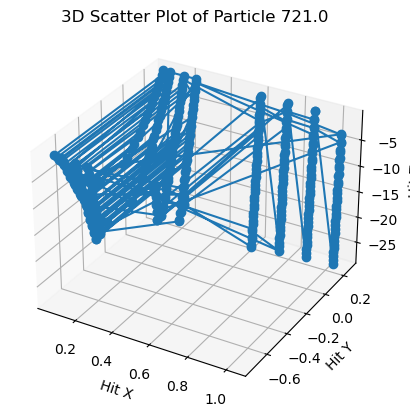

Particle ID: 731.0, Event ID: 2131


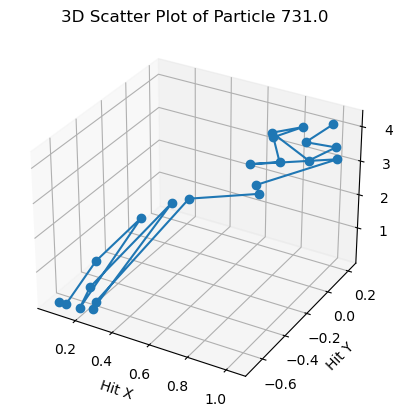

Particle ID: 760.0, Event ID: 2013


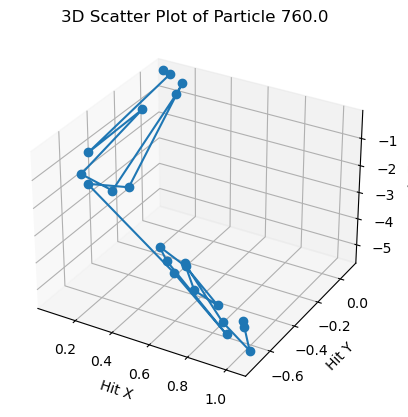

Particle ID: 767.0, Event ID: 2193


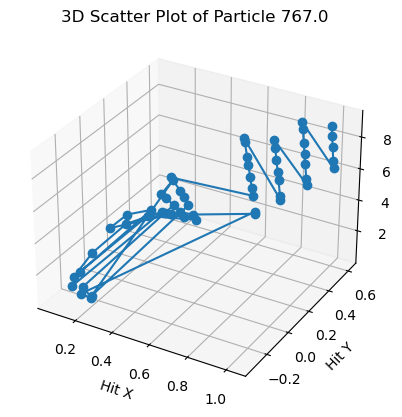

Particle ID: 768.0, Event ID: 2193


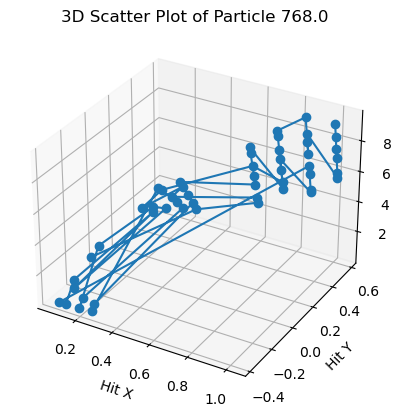

Particle ID: 847.0, Event ID: 2081


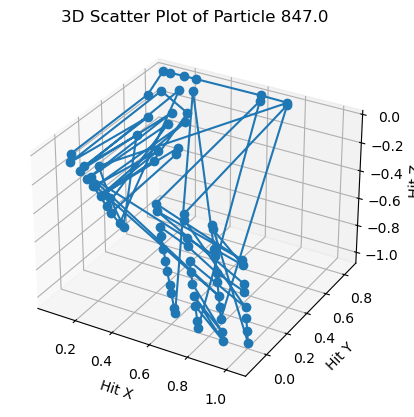

Particle ID: 848.0, Event ID: 2081


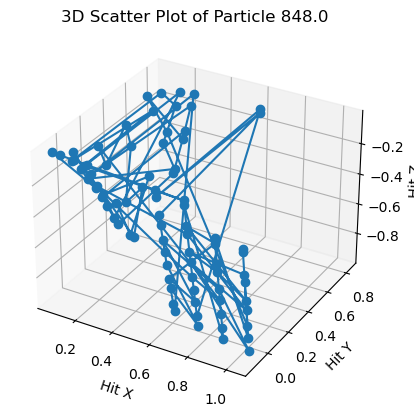

Particle ID: 857.0, Event ID: 2007


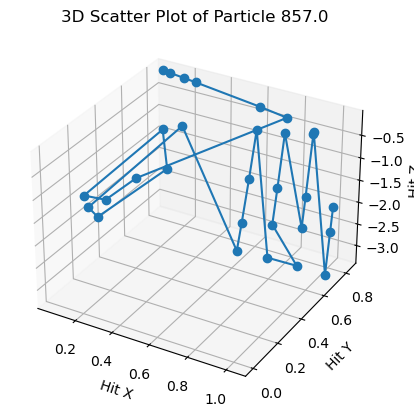

Particle ID: 858.0, Event ID: 2007


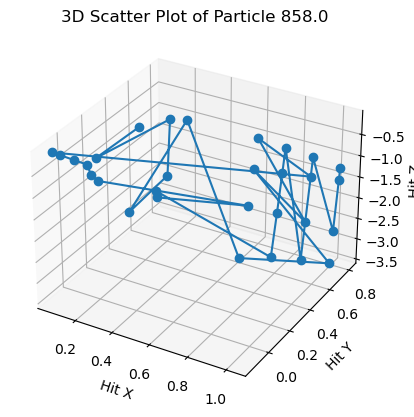

Particle ID: 863.0, Event ID: 2175


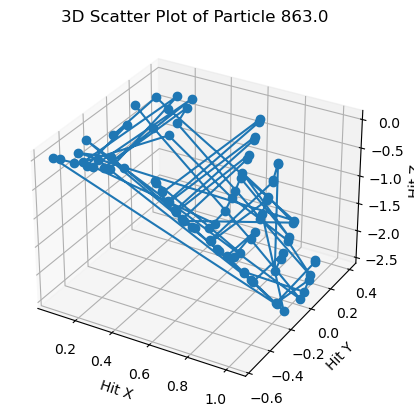

Particle ID: 864.0, Event ID: 2071


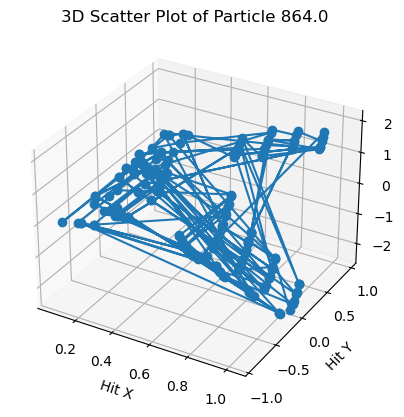

Particle ID: 865.0, Event ID: 2071


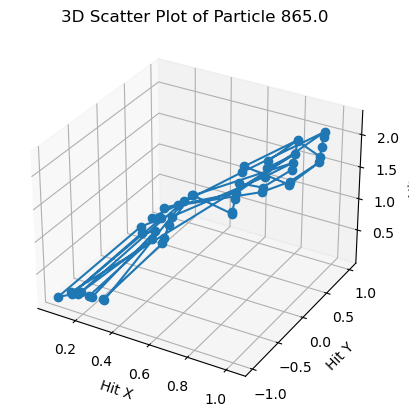

Particle ID: 905.0, Event ID: 2089


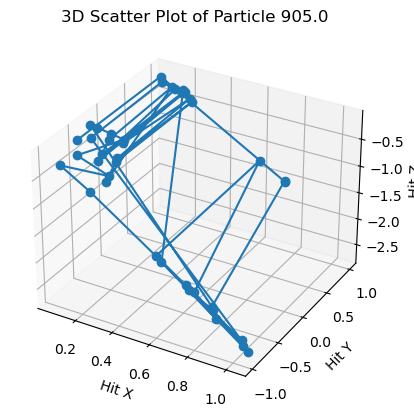

Particle ID: 906.0, Event ID: 2089


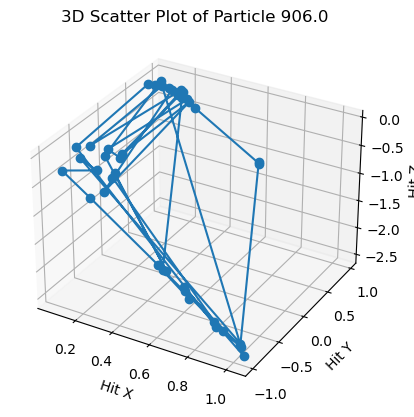

Particle ID: 955.0, Event ID: 2182


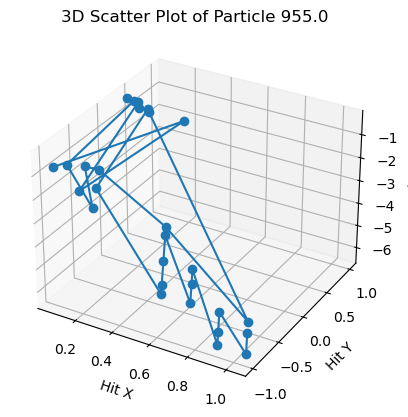

Particle ID: 956.0, Event ID: 2182


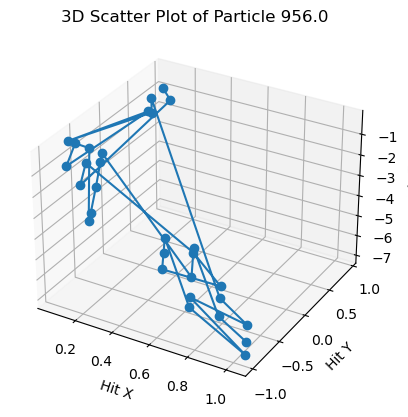

Particle ID: 965.0, Event ID: 2100


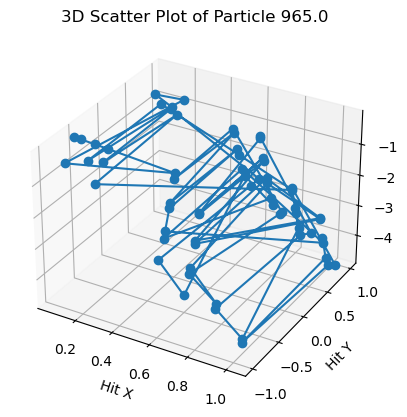

Particle ID: 966.0, Event ID: 2100


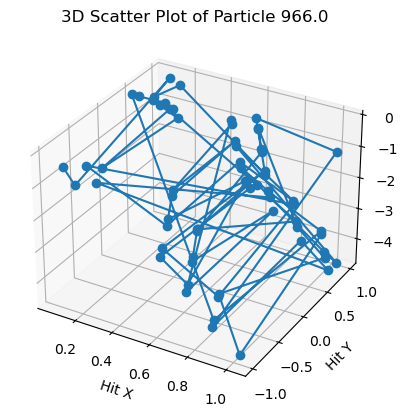

Particle ID: 1012.0, Event ID: 2199


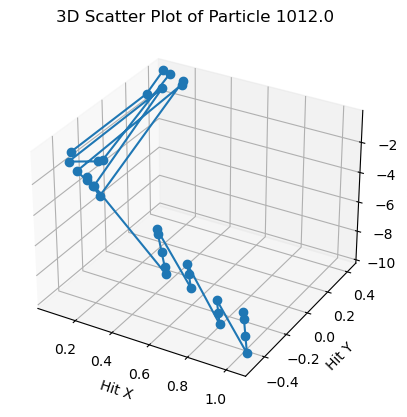

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# 假设reconstruct_data是一个Pandas DataFrame
filtered_data = particles_data[particles_data['n_true_hits'] > 20]
grouped_data = filtered_data.groupby('particle_id')

count = 0
for particle_id, group in grouped_data:
    if count < 50:
        x = group["hit_x"]
        y = group["hit_y"]
        z = group["hit_z"]

    # 创建一个3D图形
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    # 绘制散点图
        #ax.scatter(x, y, z, c='blue', marker='o')
        ax.plot(x, y, z, marker='o', linestyle='-')

    # 设置坐标轴标签
        ax.set_xlabel('Hit X')
        ax.set_ylabel('Hit Y')
        ax.set_zlabel('Hit Z')
        
        event_id = group.iloc[0]['event_id']
        print(f'Particle ID: {particle_id}, Event ID: {event_id}')

    # 设置图形标题
        ax.set_title(f'3D Scatter Plot of Particle {particle_id}')
        count += 1
    else:
        break

    # 显示图形
    plt.show()
    

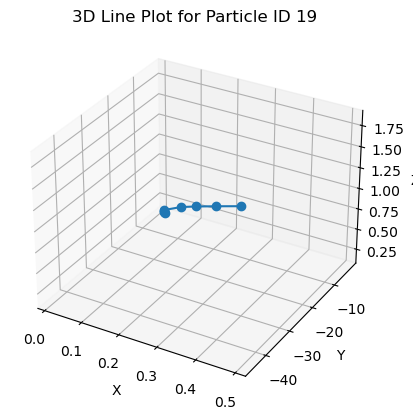

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 读取 CSV 文件
df = pd.read_csv("../QuirkTracking/datasets/Lambda500/Quirk/event000002059-hits.csv")

# 转换 r, phi, z 到 x, y, z
df['x'] = df['r'] * np.cos(df['phi']) / 50.
df['y'] = df['r'] * np.sin(df['phi'])
df['z'] = df['z'] / 100.

particle_id_19_data = df[df['particle_id'] == 19]

# 创建一个 3D 图形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = particle_id_19_data['x']
y = particle_id_19_data['y']
z = particle_id_19_data['z']

# 绘制连线
ax.plot(x, y, z, marker='o', linestyle='-')

# 设置坐标轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 设置图形标题
ax.set_title('3D Line Plot for Particle ID 19')

# 显示图形
plt.show()


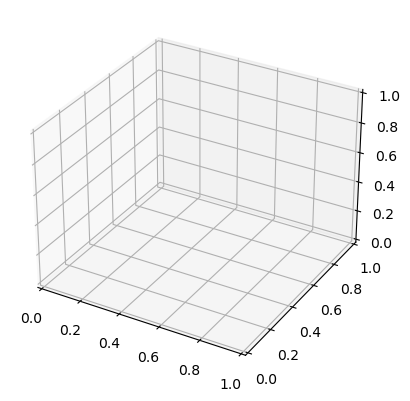

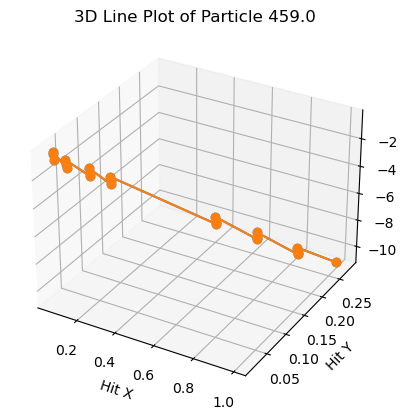

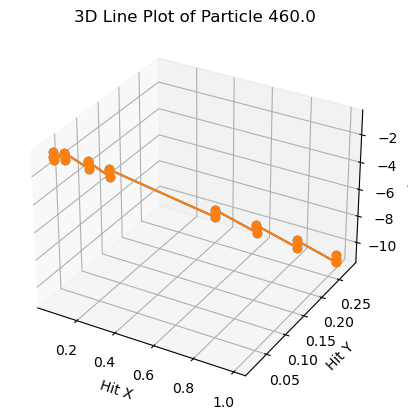

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 读取 CSV 文件
df = pd.read_csv("../QuirkTracking/datasets/Lambda500/Quirk/event000002065-hits.csv")

# 转换 r, phi, z 到 x, y, z
df['r'] = (df['r'])/50.
df[('phi')] = df[('phi')]/(np.pi)

df['x'] = (df['r']) * np.cos(df[('phi')])
df['y'] = (df['r']) * np.sin(df[('phi')])
df['z'] = df['z'] / 100.

# 根据 particle_id 分组
grouped_data = df.groupby('particle_id')

# 创建一个 3D 图形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 循环处理每个粒子
for particle_id, group in grouped_data:
    x = group['x']
    y = group['y']
    z = group['z']

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # 绘制连线
    ax.plot(x, y, z, marker='o', linestyle='-')

    # 设置坐标轴标签
    ax.set_xlabel('Hit X')
    ax.set_ylabel('Hit Y')
    ax.set_zlabel('Hit Z')

    # 设置图形标题
    ax.set_title(f'3D Line Plot of Particle {particle_id}')

    # 绘制连线
    ax.plot(x, y, z, marker='o', linestyle='-')

# 显示图形
plt.show()